In [2]:
!conda install -y librosa

Solving environment: done

## Package Plan ##

  environment location: /anaconda3

  added / updated specs:
    - librosa


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    audioread-2.1.8            |   py37hc8dfbb8_2          32 KB  conda-forge
    ffmpeg-4.2                 |       h5c2b479_0        43.3 MB  conda-forge
    gnutls-3.6.13              |       hc269f14_0         2.1 MB  conda-forge
    lame-3.100                 |    h1de35cc_1001         527 KB  conda-forge
    libflac-1.3.3              |       h4a8c4bd_0         351 KB  conda-forge
    libogg-1.3.2               |    h0b31af3_1002         203 KB  conda-forge
    librosa-0.7.2              |             py_1         1.5 MB  conda-forge
    libsndfile-1.0.28          |    h4a8c4bd_1000         540 KB  conda-forge
    libvorbis-1.3.7            |       h4a8c4bd_0         248 KB  conda-forge
    nettle-3.4.1              

In [5]:
import numpy as np
import pandas as pd
import time
import librosa
import librosa.display

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from boris_util import *

In [6]:
# https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0


y, sr = librosa.load('453_923_bundle_archive/set_a/murmur__201108222255.wav')

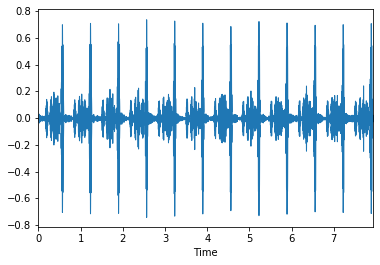

In [7]:
librosa.display.waveplot(y, sr=sr);

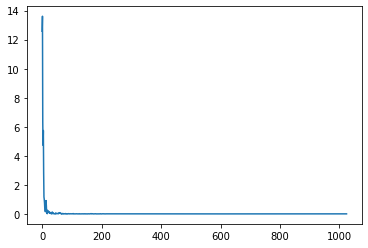

In [43]:
n_fft = 2048
D = np.abs(librosa.stft(y[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
plt.plot(D);

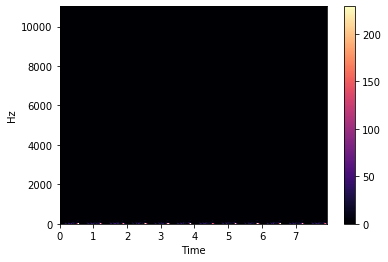

In [44]:
hop_length = 512
D = np.abs(librosa.stft(y, n_fft=n_fft,  hop_length=hop_length))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear');
plt.colorbar();

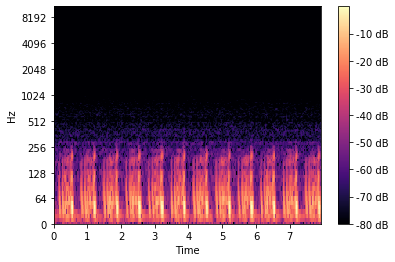

In [45]:
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

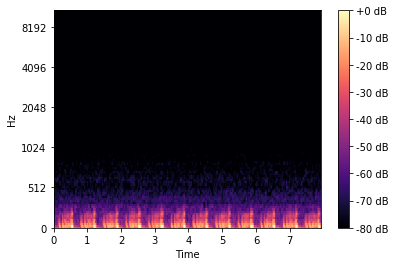

In [46]:
S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

In [47]:
S_DB.shape

(128, 342)

In [49]:
S

array([[5.35081196e+00, 6.21693754e+00, 3.15149403e+00, ...,
        1.82468250e+03, 1.14468945e+03, 6.98612747e+01],
       [1.38783264e+00, 7.02522933e-01, 3.34920585e-01, ...,
        2.49061621e+03, 1.32776440e+03, 7.73757019e+01],
       [1.05154455e-01, 7.04295337e-02, 7.17625618e-02, ...,
        1.16793015e+02, 8.82428589e+01, 8.66263390e+00],
       ...,
       [1.00712941e-06, 2.62496712e-07, 1.15781793e-08, ...,
        1.94690308e-08, 1.55095030e-08, 1.36405333e-07],
       [1.58318232e-06, 3.99091192e-07, 4.68354067e-09, ...,
        3.36263950e-09, 4.64323868e-09, 2.56712099e-07],
       [1.80218137e-06, 4.50799092e-07, 1.47477461e-10, ...,
        3.23353982e-10, 1.05058084e-09, 2.87701056e-07]], dtype=float32)

# Exploring the Dataset

First thing's first, let's load the dataset. I created a new function that loads up the dataset for me and converts it into a pandas dataframe for easy access. For more information on this, please see the `Data Cleaning` notebook

In [ ]:
dataset = read_original_data('453_923_bundle_archive')
print(dataset.shape)
dataset.head()

Let's take a look at the class distribution to see if there is any concern of class imbalance

In [ ]:
label_counts = dataset['label'].value_counts()

plt.figure(figsize=(15,5))
plt.barh(label_counts.index, label_counts.values)
plt.xlabel("Value Counts")
plt.ylabel("Condition")
plt.title("The Distribution of Different Labels in the Dataset")
plt.show()

There is certainly an issue of class imbalance here. A naive classifier could guess pretty well by simply guessing "Normal" on all the examples

## Basic Model - Logistic Regression

Let's start by establishing a baseline performance. I am just going to load the raw audio data as features (where each feature is an audio measurement) and see how well a simple logistic regression (linear model) and decision tree (non-linear model) will perform

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

condition_label_encoder = LabelEncoder()

X = dataset.drop('label', axis=1)


y = condition_label_encoder.fit_transform(dataset['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

In [ ]:
from sklearn.linear_model import LogisticRegression

fit_start = time.time()
my_model = LogisticRegression().fit(X_train, y_train)
fit_end = time.time()
print(f"Fitting took {round(fit_end - fit_start,2)} seconds")

train_acc = my_model.score(X_train, y_train)
test_acc = my_model.score(X_test, y_test)

In [ ]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

Extremely suspicious results. There is clearly a very large sign of overfitting here. Let's explore how the logistic regression makes decisions.

Let's plot the coefficients as if they were an audio mask (which is really what they end up becoming).

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(np.abs(my_model.coef_).mean(axis=0))
plt.xlabel("Timestamp")
plt.ylabel("Coefficient Absolute Mean Value")
plt.title("Logistic Regression Coefficients")
plt.show()

Most of the decision is happening at the end of the sound bite. It looks like we can chop all audio clips to the last 10,000 sound measurements and get comparable results

In [ ]:
X_truncated = X.iloc[:, -100000:]

X_train, X_test, y_train, y_test = train_test_split(X_truncated, y, test_size=0.2, stratify=y, random_state=1)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

In [ ]:
from sklearn.linear_model import LogisticRegression

fit_start = time.time()
my_model = LogisticRegression().fit(X_train, y_train)
fit_end = time.time()
print(f"Fitting took {round(fit_end - fit_start,2)} seconds")

train_acc = my_model.score(X_train, y_train)
test_acc = my_model.score(X_test, y_test)

print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

Interestingly for the logistic regression I got comparable performance with only $\frac{1}{3}$ of the run time.

## Basic Model - Decision Tree

As another baseline, I will train a decision tree to see if introducing non-linearity to the learning process produces better results

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

fit_start = time.time()
# Let's set some regularization otherwise we know the tree will overfit
my_model = DecisionTreeClassifier(min_samples_leaf=2).fit(X_train, y_train)
fit_end = time.time()
print(f"Fitting took {round(fit_end - fit_start,2)} seconds")

train_acc = my_model.score(X_train, y_train)
test_acc = my_model.score(X_test, y_test)

In [ ]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

Much better results! However, let's see how the model performs using the confusion matrix of the test set



In [ ]:
from sklearn.metrics import plot_confusion_matrix

In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_model, X_test, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Decision Tree Confusion Matrix")
plt.show()

In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_model, X_test, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             ax=ax)
disp.ax_.set_title("Decision Tree Confusion Matrix")
plt.show()

As suspected, quite a bit of the classification seems to classify abnormal conditions and sounds as "normal" due to the sheer volume of that class, but interestingly, ~39% of the normal examples get misclassified as abnormalities.

Let's see which feature the tree considers important:

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(my_model.feature_importances_)
plt.xlabel("Timestamp")
plt.ylabel("Feature Importance")
plt.title("Decision Tree Feature Importance")
plt.show()